# Data loader
12 users geo-spatial and kinematic features

## Load Data

### Load GPS+GIS fusion tensors - dimensionality 9x9x11 - ( [see explaination here](https://www.sciencedirect.com/science/article/pii/S0968090X20307385?dgcid=author#bfn4))

Remember to delete "image_data" after training, before loading "image_data" with the user_test partition, so that the dataloader can perform the test on your network, with weights and biases resulting from the training.

In [3]:
import os
working_path = '/content/drive/My Drive/s182190/data'
os.chdir(f'{working_path}')
from src.data_utils_conda import *

dataset = pd.read_pickle(f'{working_path}/processed/dataset_merged.pkl')

## Create train validation and test partitions

Since user 4 and 9 have lots of points, We use k parameter to define a specific slice of the train, validation and test collection. If you want to learn more, please go to the data utilis.py. 

For the formal test later of the algorithm, the -random- parameter is set to be True, k is not invoked.

In [4]:
user_train, user_val, user_test = train, val, test = train_test_data_split(dataset.user.unique(),Random=False, k=9) # use specified splits, check the source code
print(f'partition: train {user_train}, validation {user_val}, test {user_test}')

data_train =  pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test]).reset_index(drop=True)

print(f'length: train {len(data_train)}, validation {len(data_val)}, test {len(data_test)}')

data_train.head(10)

partition: train [4, 1, 8, 12, 11, 7, 10, 5], validation [9], test [3, 2, 6]
length: train 585391, validation 200669, test 62031


,user,ts,image_ix,x,y,x_web,y_web,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,mode,purpose
0,4,2018-06-15-05,3,1.405763e+06,7.485806e+06,1.405763e+06,7.485806e+06,2,0.0,5.0,126.0,167.688110,-1.169201,1.330858,0,1,0,1,Light Rail,-100
1,4,2018-06-15-08,3684,1.394213e+06,7.516659e+06,1.394213e+06,7.516659e+06,1,4.0,0.0,2139.0,6.735206,1.248921,0.003149,1,29,0,2,-100,Formal
2,4,2018-06-15-08,3685,1.394209e+06,7.516648e+06,1.394209e+06,7.516648e+06,1,4.0,0.0,17.0,10.977184,-1.906872,0.645717,1,29,1,2,-100,Formal
3,4,2018-06-15-08,3688,1.394214e+06,7.516664e+06,1.394214e+06,7.516664e+06,1,4.0,0.0,82.0,16.436425,1.248127,0.200444,1,30,0,2,-100,Formal
4,4,2018-06-15-08,3689,1.394213e+06,7.516659e+06,1.394213e+06,7.516659e+06,1,4.0,0.0,41.0,5.115697,-1.864637,0.124773,1,30,1,2,-100,Formal
5,4,2018-06-15-08,3692,1.394216e+06,7.516667e+06,1.394216e+06,7.516667e+06,1,4.0,0.0,103.0,8.163831,1.237253,0.079260,1,31,0,1,-100,Formal
6,4,2018-06-15-08,3693,1.394215e+06,7.516665e+06,1.394215e+06,7.516665e+06,1,4.0,0.0,756.0,2.301488,-1.928052,0.003044,1,32,0,1,-100,Formal
7,4,2018-06-15-08,3694,1.394213e+06,7.516659e+06,1.394213e+06,7.516659e+06,1,4.0,0.0,134.0,6.354567,-1.932308,0.047422,1,33,0,1,-100,Formal
8,4,2018-06-15-08,3696,1.394216e+06,7.516667e+06,1.394216e+06,7.516667e+06,1,4.0,0.0,114.0,8.325730,1.206465,0.073033,1,34,0,1,-100,Formal
9,4,2018-06-15-08,3697,1.394216e+06,7.516667e+06,1.394216e+06,7.516667e+06,1,4.0,0.0,140.0,0.000000,0.000000,0.000000,1,35,0,1,-100,Formal


Remember to delete "image_data" after training, before loading "image_data" with the user_test partition, so that the dataloader can perform the test on your network, with weights and biases resulting from the training.

In [5]:
image_data = {}
for user_id in (user_train + user_val + user_test):
        image_data[user_id] = np.stack(decompress_pickle(f'{working_path}/interm/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
        print(f'User {user_id}, image shape {image_data[user_id].shape}')

User 4, image shape (667160, 9, 9, 11)
User 1, image shape (17990, 9, 9, 11)
User 8, image shape (112, 9, 9, 11)
User 12, image shape (117610, 9, 9, 11)
User 11, image shape (28845, 9, 9, 11)
User 7, image shape (22616, 9, 9, 11)
User 10, image shape (86277, 9, 9, 11)
User 5, image shape (14112, 9, 9, 11)
User 9, image shape (425710, 9, 9, 11)
User 3, image shape (83326, 9, 9, 11)
User 2, image shape (20132, 9, 9, 11)
User 6, image shape (2344, 9, 9, 11)


### Define Image Tensor Dataloader

We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images. Just add features inside
```
df[['feat1','feat2',...]]
```

In [6]:
import torch
class ImageTensorDataset(torch.utils.data.Dataset):
    filter_seq = 5
    def __init__(self, df, image_data,filter_seq=filter_seq):
        self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(filter_seq, -1, -1)], axis = 1)
        self.seq = self.seq[df['segment_ix'] >= filter_seq]

        self.label2 = df[df['segment_ix'] >= filter_seq]['label2'].values # need to transfer from 1,2 to 0,1
        self.labelM = df[df['segment_ix'] >= filter_seq]['labelM'].values
        self.labelP = df[df['segment_ix'] >= filter_seq]['labelP'].values
     
        self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values
        self.image_ix = df[df['segment_ix'] >= filter_seq]['image_ix'].values        
        self.image_data = image_data
        tod = df[df['segment_ix'] >= filter_seq]['tod'].values
        self.tod_one_hot = np.eye(5)[tod]
        
    def __len__(self):
        return len(self.label2)
    
    def __getitem__(self, key):
        image = self.image_data[self.user_id[key]][self.image_ix[key]]
        return image, self.seq[key], self.tod_one_hot[key], self.label2[key] - 1, self.labelM[key], self.labelP[key]

demo_dataset = ImageTensorDataset(data_train, image_data)
demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=3, shuffle=True)

for X_img, X_seq, X_tod, y1, y2, y3 in demo_loader:
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y1:', y2.shape)
    print(y1[0])
    print(y2[0])
    print(y3[0])
    break;

X_img : torch.Size([3, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([3, 6, 2])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
X_tod : torch.Size([3, 5])
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
y1: torch.Size([3])
tensor(0)
tensor(0., dtype=torch.float64)
tensor(5., dtype=torch.float64)


In [7]:
len(demo_loader)

182503

### define train, val, test set and dataloader

In [8]:
    train_dataset = ImageTensorDataset(data_train, image_data)
    val_dataset = ImageTensorDataset(data_val, image_data)
    test_dataset = ImageTensorDataset(data_test, image_data)

# Model CNN_RNN_GIS_Multi_Targets
If we want to classify not only stop/move status, but also trip purpose and travel mode. In this case, stop/move has two status, trip purpose has 16 status, and travel mode has 9 status. So, in total, it is 27 status. We try to modify the last layer of fully connected network to be 27 neurons and when doing loss computation, the target is also split into three catagory, each catagory has its own loss, with finnaly three loss combined into One total loss.

In [9]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from collections import OrderedDict
torch.manual_seed(1) # 设置随机种子，保证可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 设置使用CPU or GPU

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## Network

In [27]:
# use to select the output of RNN out from the tuple in nn.sequential
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

class Net_CNN_RNN_GIS_Multi_Purpose(nn.Module):
    def __init__(self):
        super(Net_CNN_RNN_GIS_Multi_Purpose, self).__init__()
        self.cnn = nn.Sequential(OrderedDict([
                                              ('conv1', nn.Conv2d(in_channels = 11, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)),
                                              ('pool1', nn.MaxPool2d(kernel_size = 3, stride = 1)),
                                              ('norm1', nn.BatchNorm2d(num_features = 16)),
                                              ('relu1', nn.ReLU()),
                                              ('drop1', nn.Dropout2d(p = 0.45, inplace = True)),
                                              ('conv2', nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)),
                                              ('pool2', nn.MaxPool2d(kernel_size = 2, stride = 1)),
                                              ('norm2', nn.BatchNorm2d(num_features = 8)),
                                              ('relu2', nn.ReLU()),
                                              ('drop2', nn.Dropout2d(p = 0.45, inplace = True)),
                                              ('flat', nn.Flatten()),
        ]))

        self.rnn = nn.Sequential(OrderedDict([
                                              ('bi-gru1', nn.GRU(input_size = 2, hidden_size = 5, num_layers = 4, batch_first = True, bidirectional = True, bias = False)),
                                              ('drop_h0', SelectItem(0)),
                                              ('drop1', nn.Dropout(p = 0.5)),
                                            #   ('layernorm', nn.LayerNorm([2*5])),
                                              ('flat', nn.Flatten())
        ]))

        self.fc = nn.Sequential(OrderedDict([
                                             ('fc1', nn.Linear(in_features = 8 * 6 * 6 + 6 * 10 + 5, out_features = 512)),
                                             ('relu1', nn.ReLU()),
                                             ('fc2', nn.Linear(in_features = 512, out_features = 100)),
                                             ('relu2', nn.ReLU()),
                                             ('fc3', nn.Linear(in_features = 100, out_features = 12 )),
                                             
        ]))

    def forward(self, X_img, X_seq, X_tod):
        x1 = self.cnn(X_img.permute(0, 3, 1, 2)) # change from (N,H,W,C) to (N, C, H, W)
        x2 = self.rnn(X_seq)
        x3 = torch.cat((x1, x2, X_tod), dim = 1)
        x4 = self.fc(x3)
        
        return x4


## Main

discuss about the observations which 

In [11]:
unique, counts = np.unique(data_train['labelM'], return_counts=True)
print(f'labelM: {unique},{counts}')
weightLabelM = torch.DoubleTensor(1/counts * np.min(counts)).to(device)
print(weightLabelM)

unique, counts = np.unique(data_train['labelP'], return_counts=True)
print(f'labelP: {unique},{counts}')
weightLabelP = torch.DoubleTensor(1/counts * np.min(counts)).to(device)
print(weightLabelP)

labelM: [0. 1. 2. 3. 4. 5.],[476557  34110   3893  57720    509  12602]
tensor([0.0011, 0.0149, 0.1307, 0.0088, 1.0000, 0.0404], device='cuda:0',
       dtype=torch.float64)
labelP: [0. 1. 2. 3. 4. 5.],[108834   7102   5452   7793  84015 372195]
tensor([0.0501, 0.7677, 1.0000, 0.6996, 0.0649, 0.0146], device='cuda:0',
       dtype=torch.float64)


In [12]:
purpose_names = ["-100", "Accompany", "Change Mode", "Informal", "Formal","Home"]
mode_names = ["-100", "Mix","Bike","Bus","Walk","Light Rail"]

In [13]:

# from getpass import getpass
# api_token = getpass('Enter your private Neptune API token: ')
api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2ZhOTE4MDEtMWQxOC00NDU2LThiZGYtNTQ3NjAxMWJkOGUyIn0='

In [14]:
# eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2ZhOTE4MDEtMWQxOC00NDU2LThiZGYtNTQ3NjAxMWJkOGUyIn0=

In [15]:
# Setup Neptune
!pip install neptune-client
import neptune
neptune.init(project_qualified_name = 'losdwind/s182190',
             api_token = api_token)

     |████████████████████████████████| 122kB 12.5MB/s 
     |████████████████████████████████| 829kB 17.5MB/s 
     |████████████████████████████████| 204kB 30.3MB/s 
     |████████████████████████████████| 163kB 53.5MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 133kB 55.7MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.5.1-py2.py3-none-any.whl size=166841 sha256=79a18e5b6d90a2470803f27cbc28a57a53a79fa10c4afee411358e805e53cbf3
  Stored in directory: /root/.cache/pip/wheels/d4/86/b4/7264d87893c539c192b81bec01d3b131d7e71eba5f2936fcde
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=b05d90157f31f0a2def7d99c658bbe0690c04a2bf9636fe80a4809f58c913b6f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

Project(losdwind/s182190)

In [16]:
# use SWAG
#!pip install torchcontrib
#from torchcontrib.optim import SWA     # use SWAG
! pip install scikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn
import hashlib

# Import log_table
! pip install neptune-contrib
from neptunecontrib.api.table import log_table

     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for neptune-contrib: filename=neptune_contrib-0.27.1-cp37-none-any.whl size=81334 sha256=e67410ba10612b889e3c0d8af6919c04b17de8d5fcd7665f7fa0e6e8ebcf4d8f
  Stored in directory: /root/.cache/pip/wheels/81/79/bc/e5458e541cc4714c4fc233b1cd6deb076f310ca411f31062b4
Successfully built neptune-contrib


In [17]:
def plot_roc(y_true, y_probas, title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    """Generates the ROC curves from labels and predicted scores/probabilities
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to
            "ROC Curves".
        plot_micro (boolean, optional): Plot the micro average ROC curve.
            Defaults to ``True``.
        plot_macro (boolean, optional): Plot the macro average ROC curve.
            Defaults to ``True``.
        classes_to_plot (list-like, optional): Classes for which the ROC
            curve should be plotted. e.g. [0, 'cold']. If given class does not exist,
            it will be ignored. If ``None``, all classes will be plotted. Defaults to
            ``None``
        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the curve. If None, the plot is drawn on a new set of axes.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.
        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional):
            Colormap used for plotting the projection. View Matplotlib Colormap
            documentation for available options.
            https://matplotlib.org/users/colormaps.html
        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".
    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    Example:
        >>> import scikitplot as skplt
        >>> nb = GaussianNB()
        >>> nb = nb.fit(X_train, y_train)
        >>> y_probas = nb.predict_proba(X_test)
        >>> skplt.metrics.plot_roc(y_test, y_probas)
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
        >>> plt.show()
        .. image:: _static/examples/plot_roc_curve.png
           :align: center
           :alt: ROC Curves
    """
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = range(6)
    probas = y_probas

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i in classes:
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label= classes[i])
        if True:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc))

    if plot_micro:
        binarized_y_true = label_binarize(y_true, classes=classes)
        if len(classes) == 2:
            binarized_y_true = np.hstack(
                (1 - binarized_y_true, binarized_y_true))
        fpr, tpr, _ = roc_curve(binarized_y_true.ravel(), probas.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,
                label='micro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='deeppink', linestyle=':', linewidth=4)

    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linestyle=':', linewidth=4)

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)

    return ax

In [18]:
def CM_ROC_AUC(y_true, y_predict, y_score):
    pass

In [19]:
def main_2(train_dataset, val_dataset, test_dataset, PARAMS):

    epochs = PARAMS['epochs']
    batch_size = PARAMS['batch_size']

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)

    model = Net_CNN_RNN_GIS_Multi_Purpose().double().to(device) #
    # base_opt = optim.Adam(model.parameters(), lr= PARAMS['lr'] , weight_decay= PARAMS['weight_decay'])  # infinite weight for class with 
    # optimizer = SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=0.005)
    optimizer = optim.SGD(model.parameters(), lr =PARAMS['lr'], momentum = PARAMS['momentum'])

    # log params
    neptune.create_experiment(name = 'D_Model_MMM_MMM_Data_replace_with_geolife_RNN_network.ipynb', description = "MMM multi-label model with advanced structure working on the MMM dataset, classes are cleaned which equals 6 + 6, and users are merged " , params=PARAMS, tags = ['MMM_Model', 'Advanced', 'MMM_data','replace_with_geolife_network'])
    
    train_classesM, train_countM = np.unique(train_dataset.labelM, return_counts=True)
    train_classesP, train_countP = np.unique(train_dataset.labelP, return_counts=True)
    val_classesM, val_countM = np.unique(val_dataset.labelM, return_counts=True)
    val_classesP, val_countP = np.unique(val_dataset.labelP, return_counts=True)
    test_classesM, test_countM = np.unique(test_dataset.labelM, return_counts=True)
    test_classesP, test_countP = np.unique(test_dataset.labelP, return_counts=True)

    neptune.log_text("users", f'Train Set Users: {np.unique(train_dataset.user_id)}')
    neptune.log_text("users", f'Val Set Users: {np.unique(val_dataset.user_id)}')
    neptune.log_text("users", f'Test Set Users: {np.unique(test_dataset.user_id)}')
    neptune.log_text("classes and counts", f'train_classes and counts for mode: {train_classesM} \n {train_countM}')
    neptune.log_text("classes and counts", f'train_classes and counts for purpose: {train_classesP} \n {train_countP}')
    neptune.log_text("classes and counts", f'val_classes and counts for mode: {val_classesM} \n {val_countM}')
    neptune.log_text("classes and counts", f'val_classes and counts for purpose: {val_classesP} \n {val_countP}')
    neptune.log_text("classes and counts", f'test_classes and counts for mode: {test_classesM} \n {test_countM}')
    neptune.log_text("classes and counts", f'test_classes and counts for purpose: {test_classesP} \n {test_countP}')


    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        train_targs = []
        train_targsM = []
        train_targsP = []

        train_preds = []
        train_predsM = []
        train_predsP = []
        train_preds_probaM = []
        train_preds_probaP = []
        model.train() # 必备，将模型设置为训练模式
        for batch_idx, (X_img, X_seq, X_tod, target, targetM, targetP) in enumerate(train_loader): # 从数据加载器迭代一个batch的数据
            X_img, X_seq, X_tod, target, targetM, targetP =  X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device), target.long().to(device), targetM.long().to(device), targetP.long().to(device)  # 将数据存储CPU或者GPU
            optimizer.zero_grad() # 清除所有优化的梯度
            output = model( X_img, X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
            criterion1 = nn.CrossEntropyLoss(weight = weightLabelM) # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
            criterion2 = nn.CrossEntropyLoss(weight = weightLabelP)

            
            ## more experiments to do, weights across mode/purpose
            ## track the loss and find the influence of different modes/purpose on the total loss
            loss = criterion1(output[:,0:6], targetM)  + criterion2(output[:,6:12], targetP) # 调用损失函数计算损失
            loss.backward() # 反向传播
            optimizer.step() # 更新参数
            
            train_loss += loss * batch_size  # sum the batch loss  
            predsM = torch.max(output[:,0:6], 1)[1].cpu()
            predsP = torch.max(output[:,6:12], 1)[1].cpu() 


            
            train_targsM += targetM.tolist()
            train_predsM += predsM.tolist()

            train_targsP += targetP.tolist()
            train_predsP += predsP.tolist()
            if epoch == epochs:
                # save status
                train_preds_probaM += output[:, 0:6].tolist()
                train_preds_probaP += output[:, 6:12].tolist()    

        
        
        train_accM = accuracy_score(train_targsM, train_predsM)
        train_accP = accuracy_score(train_targsP, train_predsP)
        
        # log the train loss
        neptune.log_metric('train_loss', x = epoch, y = train_loss/len(train_loader))
        # log the train accuracy
        neptune.log_metric('train_accM', x = epoch, y = train_accM)
        neptune.log_metric('train_accP', x = epoch, y = train_accP)

        # 必备，将模型设置为评估模式
        model.eval() 
        val_loss = 0
        val_targsM = []
        val_targsP = []

        val_predsM = []
        val_predsP = []

        val_preds_probaM = []
        val_preds_probaP = []

        with torch.no_grad(): # 禁用梯度计算
            for batch_idx, (X_img, X_seq, X_tod, target, targetM, targetP) in enumerate(val_loader): # 从数据加载器迭代一个batch的数据
                X_img, X_seq, X_tod, target, targetM, targetP =  X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device), target.long().to(device), targetM.long().to(device), targetP.long().to(device)  # 将数据存储CPU或者GPU
                output = model( X_img, X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
                # put weight here???
                criterion1 = nn.CrossEntropyLoss(weight = weightLabelM)
                criterion2 = nn.CrossEntropyLoss(weight = weightLabelP)
                loss = criterion1(output[:,0:6], targetM) + criterion2(output[:,6:12], targetP) # 调用损失函数计算损失
                val_loss += loss * batch_size  # sum the batch loss   
                predsM = torch.max(output[:,0:6], 1)[1].cpu()
                predsP = torch.max(output[:,6:12], 1)[1].cpu()


                val_targsM += targetM.tolist()
                val_predsM += predsM.tolist()

                val_targsP += targetP.tolist()
                val_predsP += predsP.tolist()

                if epoch == epochs:
                    # save status
                    val_preds_probaM += output[:, 0:6].tolist()
                    val_preds_probaP += output[:, 6:12].tolist()  

            val_accM = accuracy_score(val_targsM, val_predsM)
            val_accP = accuracy_score(val_targsP, val_predsP)
            

        # log the val loss
        neptune.log_metric('val_loss', x = epoch, y = val_loss/len(val_loader))
        # log the val accuracy
        neptune.log_metric('val_accM', x = epoch, y = val_accM)
        neptune.log_metric('val_accP', x = epoch, y = val_accP)


        

        neptune.log_text('process', 'epoch: {},train_loss: {}, train_accM: {},train_accP: {}, val_loss: {}, val_accM: {}, val_accP: {}'.format(epoch ,train_loss,train_accM, train_accP, val_loss, val_accM, val_accP))
        
        if epoch == epochs:
            
            # 1
            CM_train_M = skplt.metrics.plot_confusion_matrix(train_targsM, train_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Train set')
            CM_train_M.set_xticklabels(mode_names)
            CM_train_M.set_yticklabels(mode_names)
            CM_train_M = CM_train_M.get_figure()


            # 2
            CM_train_P = skplt.metrics.plot_confusion_matrix(train_targsP, train_predsP, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Purpose Classification on Train set')
            CM_train_P.set_xticklabels(purpose_names)
            CM_train_P.set_yticklabels(purpose_names)
            CM_train_P = CM_train_P.get_figure()


            # 3
            CM_val_M = skplt.metrics.plot_confusion_matrix(val_targsM, val_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Validation set')
            CM_val_M.set_xticklabels(mode_names)
            CM_val_M.set_yticklabels(mode_names)
            CM_val_M = CM_val_M.get_figure()


            #4
            CM_val_P = skplt.metrics.plot_confusion_matrix(val_targsP, val_predsP, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Purpose Classification on Validation set')
            CM_val_P.set_xticklabels(purpose_names)
            CM_val_P.set_yticklabels(purpose_names)
            CM_val_P = CM_val_P.get_figure()

            CL_train_M = pd.DataFrame(classification_report(train_targsM, train_predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict= True)).transpose()
            CL_train_P = pd.DataFrame(classification_report(train_targsP, train_predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict=True)).transpose()
            CL_val_M = pd.DataFrame(classification_report(val_targsM, val_predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict=True)).transpose()
            CL_val_P = pd.DataFrame(classification_report(val_targsP, val_predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict=True)).transpose()

            # Log ROC Curve

            # 1
            fig1, ax1 = plt.subplots()
            plot_roc(train_targsM, train_preds_probaM,title="ROC_AUC Curve of Mode detection on Train Set", ax=ax1, figsize=(16, 12))
            neptune.log_image('training', fig1)

            # 2
            fig2, ax2 = plt.subplots()
            plot_roc(train_targsP, train_preds_probaP,title="ROC_AUC Curve of Purpose Classification on Train Set", ax=ax2, figsize=(16, 12))
            neptune.log_image('training', fig2)

            # 3
            fig3, ax3 = plt.subplots()
            print(np.array(val_targsM).shape, np.array(val_preds_probaM).shape)
            plot_roc(val_targsM, val_preds_probaM, title="ROC_AUC Curve of Mode detection on Validation Set", ax=ax3, figsize=(16, 12))
            neptune.log_image('validation', fig3)

            # 4
            fig4, ax4 = plt.subplots()
            plot_roc(val_targsP, val_preds_probaP, title="ROC_AUC Curve of Purpose Classification on Validation Set", ax=ax4, figsize=(16, 12))
            neptune.log_image('validation', fig4)
            
            # Log confusion matrix to experiment
            neptune.log_image('training', CM_train_M)            
            neptune.log_image('training', CM_train_P)
            neptune.log_image('validation', CM_val_M)
            neptune.log_image('validation', CM_val_P)


            # log classification report to experiment
            log_table('training - classification_report - mode detection', CL_train_M)
            log_table('training - classification_report - purpose classification', CL_train_P)
            log_table('validation - classification_report - mode detection', CL_val_M)
            log_table('validaiton - classification_report - purpose classification', CL_val_P)



    ### Evaluate test set

    for X_img, X_seq, X_tod,  target, targetM, targetP in test_loader:
        output = model(X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device))
        predsM = torch.max(output[:,0:6], 1)[1].cpu()
        predsP = torch.max(output[:,6:12], 1)[1].cpu()



    cl_report_2 = pd.DataFrame(classification_report(targetM, predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict=True)).transpose()         # output_dict= True
    cl_report_3 = pd.DataFrame(classification_report(targetP, predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict= True)).transpose()
    log_table('testing -  classificaiton report - mode detection', cl_report_2)
    log_table('testing -  classificaiton report - purpose imputation', cl_report_3)

    
    CM_test_M = skplt.metrics.plot_confusion_matrix(targetM, predsM, normalize=True, x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Test set')
    CM_test_M.set_xticklabels(mode_names)
    CM_test_M.set_yticklabels(mode_names)
    CM_test_M = CM_test_M.get_figure()


    CM_test_P = skplt.metrics.plot_confusion_matrix(targetP, predsP, normalize=True, x_tick_rotation=45, title='Confusion Matrix of Purpose classification on Test set')
    CM_test_P.set_xticklabels(purpose_names)
    CM_test_P.set_yticklabels(purpose_names)
    CM_test_P = CM_test_P.get_figure()


    neptune.log_image('testing', CM_test_M)
    neptune.log_image('testing', CM_test_P)

    fig5, ax5 = plt.subplots()
    plot_roc(targetM, output[:,0:6].tolist() , title="ROC_AUC Curve of Mode Detection on Test Set", ax=ax5, figsize=(16, 12))
    neptune.log_image('testing', fig5)

    fig6, ax6 = plt.subplots()
    plot_roc(targetP, output[:,6:12].tolist(), title="ROC_AUC Curve of Purpose Classification on Test Set", ax=ax6, figsize=(16, 12))
    neptune.log_image('testing', fig6)

    test_accM = accuracy_score(targetM, predsM)
    test_accP = accuracy_score(targetP, predsP)

    neptune.log_text("accuracy score of the test set", f'mode: {test_accM}, purpose: {test_accP}')

    # Log data version as experiment property
    # neptune.set_property('train_dataset_version', hashlib.md5(train_dataset).hexdigest())
    # neptune.set_property('val_dataset_version', hashlib.md5(val_dataset).hexdigest())
    # neptune.set_property('test_dataset_version', hashlib.md5(test_dataset).hexdigest())

    torch.save(model, 'MMM_Model_Advance_MMM_data.pt')
    neptune.log_artifact('MMM_Model_Advance_MMM_data.pt', 'model_checkpoints/MMM_Model_Advance_MMM_data.pt')
    
    return test_accM + test_accP

Wed Feb 24 08:03:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |   3597MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

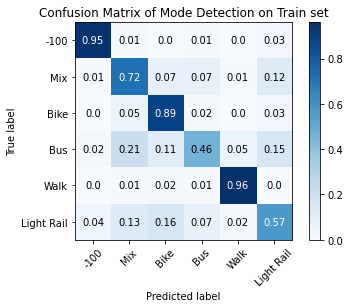

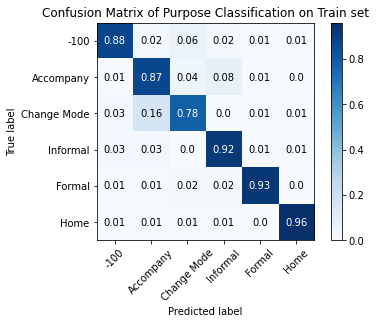

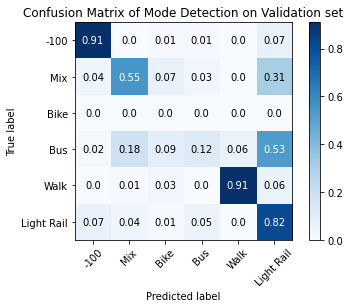

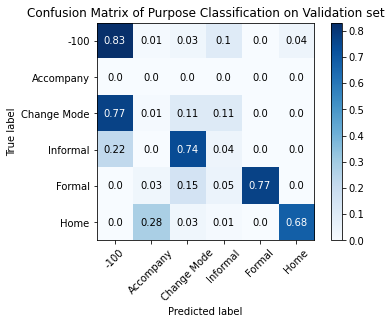

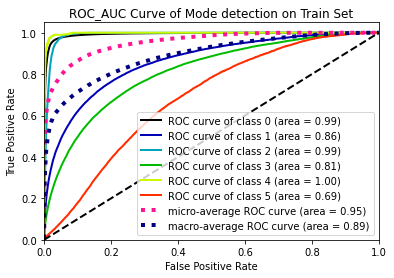

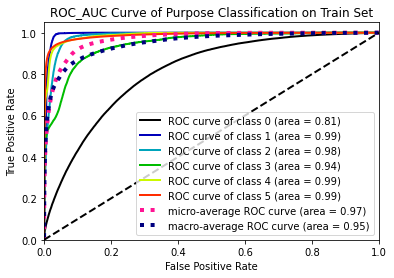

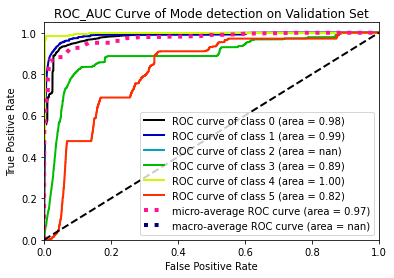

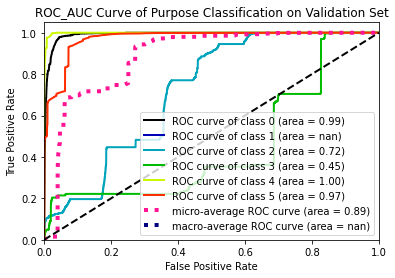

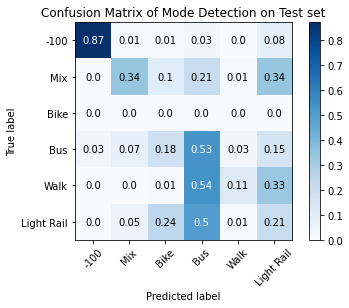

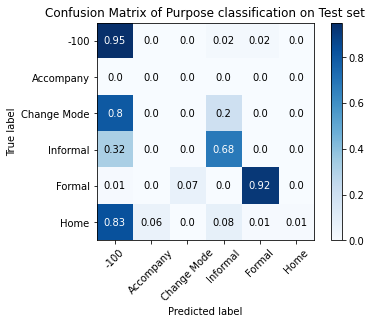

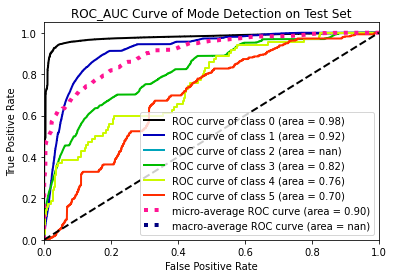

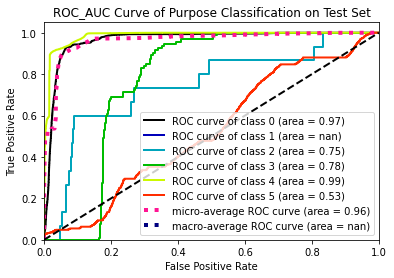

In [28]:
!nvidia-smi
PARAMS = {'lr':0.095, 
        'momentum':0.21,
        'batch_size': 13500,
        'epochs':40}
# run main_2()
try:
    main_2(train_dataset, val_dataset, test_dataset, PARAMS)
finally:
    neptune.stop()



```
# This is formatted as code
```

# Use Optuna

In [ ]:

def objective(trial):
    PARAMS = {'lr':trial.suggest_loguniform('lr', 1e-3, 1e-1), 
        'momentum':trial.suggest_uniform('momentum', 0.0, 1.0),
        'batch_size': trial.suggest_int('batch_size', 10000, 50000, step=10000),
        'epochs':trial.suggest_int('epochs', 5, 50, step=5)
        }
    
    accuracy = main_2(train_dataset, val_dataset, test_dataset, PARAMS)
    
    return accuracy

In [ ]:
! pip install --quiet optuna==2.3.0 lightgbm==3.1.0 plotly==4.13.0 neptune-client==0.4.132 neptune-contrib[monitoring]==0.25.0
import neptunecontrib.monitoring.optuna as opt_utils
neptune.create_experiment('optuna-sweep')
neptune_callback = opt_utils.NeptuneCallback(log_study=True, log_charts=True)
import optuna
try: 
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, callbacks=[neptune_callback])
finally:
    neptune.stop()

# Main with Combined Metric

In [ ]:
# use to select the output of RNN out from the tuple in nn.sequential
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

class Net_CNN_RNN_GIS_Multi_Purpose(nn.Module):
    def __init__(self):
        super(Net_CNN_RNN_GIS_Multi_Purpose, self).__init__()
        self.cnn = nn.Sequential(OrderedDict([
                                              ('conv1', nn.Conv2d(in_channels = 11, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)),
                                              ('pool1', nn.MaxPool2d(kernel_size = 3, stride = 1)),
                                              ('norm1', nn.BatchNorm2d(num_features = 16)),
                                              ('relu1', nn.ReLU()),
                                              ('drop1', nn.Dropout2d(p = 0.45, inplace = True)),
                                              ('conv2', nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)),
                                              ('pool2', nn.MaxPool2d(kernel_size = 2, stride = 1)),
                                              ('norm2', nn.BatchNorm2d(num_features = 8)),
                                              ('relu2', nn.ReLU()),
                                              ('drop2', nn.Dropout2d(p = 0.45, inplace = True)),
                                              ('flat', nn.Flatten()),
        ]))

        self.rnn = nn.Sequential(OrderedDict([
                                              ('bi-gru1', nn.GRU(input_size = 2, hidden_size = 5, num_layers = 2, batch_first = True, bidirectional = True)),
                                              ('drop_h0', SelectItem(0)),
                                            #   ('bi-gru2', nn.GRU(input_size = 10, hidden_size = 5, num_layers = 2, batch_first = True, bidirectional = True)),
                                            #   ('drop_h1', SelectItem(0)),
                                            #   ('norm1', nn.BatchNorm1d(num_features = 6 )),
                                              ('relu1', nn.ReLU()),
                                              ('drop1', nn.Dropout(p = 0.45, inplace = True)),
                                              ('flat', nn.Flatten())
        ]))

        self.fc = nn.Sequential(OrderedDict([
                                             ('fc1', nn.Linear(in_features = 8 * 6 * 6 + 6 * 10 + 5, out_features = 512)),
                                             ('relu1', nn.ReLU()),
                                             ('fc2', nn.Linear(in_features = 512, out_features = 100)),
                                             ('relu2', nn.ReLU()),
                                             ('fc3', nn.Linear(in_features = 100, out_features = 6 )),
                                             
        ]))

    def forward(self, X_img, X_seq, X_tod):
        x1 = self.cnn(X_img.permute(0, 3, 1, 2)) # change from (N,H,W,C) to (N, C, H, W)
        x2 = self.rnn(X_seq)
        x3 = torch.cat((x1, x2, X_tod), dim = 1)
        x4 = self.fc(x3)
        
        return x4


In [ ]:
def main_2(train_dataset, val_dataset, test_dataset, PARAMS):

    epochs = PARAMS['epochs']
    batch_size = PARAMS['batch_size']

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)

    model = Net_CNN_RNN_GIS_Multi_Purpose().double().to(device) #
    # base_opt = optim.Adam(model.parameters(), lr= PARAMS['lr'] , weight_decay= PARAMS['weight_decay'])  # infinite weight for class with 
    # optimizer = SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=0.005)
    optimizer = optim.SGD(model.parameters(), lr =PARAMS['lr'], momentum = PARAMS['momentum'])

    # log params
    neptune.create_experiment(name = 'MMM_Model_Advanced_MMM_b', description = "MMM multi-label model with advanced structure working on the MMM dataset, classes are cleaned which equals 6 + 6, and users are merged " , params=PARAMS, tags = ['MMM_Model', 'Advanced', 'MMM_data'])
    
    train_classesM, train_countM = np.unique(train_dataset.labelM, return_counts=True)
    train_classesP, train_countP = np.unique(train_dataset.labelP, return_counts=True)
    val_classesM, val_countM = np.unique(val_dataset.labelM, return_counts=True)
    val_classesP, val_countP = np.unique(val_dataset.labelP, return_counts=True)
    test_classesM, test_countM = np.unique(test_dataset.labelM, return_counts=True)
    test_classesP, test_countP = np.unique(test_dataset.labelP, return_counts=True)

    neptune.log_text("users", f'Train Set Users: {np.unique(train_dataset.user_id)}')
    neptune.log_text("users", f'Val Set Users: {np.unique(val_dataset.user_id)}')
    neptune.log_text("users", f'Test Set Users: {np.unique(test_dataset.user_id)}')
    neptune.log_text("classes and counts", f'train_classes and counts for mode: {train_classesM} \n {train_countM}')
    neptune.log_text("classes and counts", f'train_classes and counts for purpose: {train_classesP} \n {train_countP}')
    neptune.log_text("classes and counts", f'val_classes and counts for mode: {val_classesM} \n {val_countM}')
    neptune.log_text("classes and counts", f'val_classes and counts for purpose: {val_classesP} \n {val_countP}')
    neptune.log_text("classes and counts", f'test_classes and counts for mode: {test_classesM} \n {test_countM}')
    neptune.log_text("classes and counts", f'test_classes and counts for purpose: {test_classesP} \n {test_countP}')


    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        train_targs = []
        train_targsM = []
        train_targsP = []

        train_preds = []
        train_predsM = []
        train_predsP = []
        train_preds_probaM = []
        train_preds_probaP = []
        model.train() # 必备，将模型设置为训练模式
        for batch_idx, (X_img, X_seq, X_tod, target, targetM, targetP) in enumerate(train_loader): # 从数据加载器迭代一个batch的数据
            X_img, X_seq, X_tod, target, targetM, targetP =  X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device), target.long().to(device), targetM.long().to(device), targetP.long().to(device)  # 将数据存储CPU或者GPU
            optimizer.zero_grad() # 清除所有优化的梯度
            output = model( X_img, X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
            criterion1 = nn.CrossEntropyLoss(weight = weightLabelM) # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
            criterion2 = nn.CrossEntropyLoss(weight = weightLabelP)

            
            ## more experiments to do, weights across mode/purpose
            ## track the loss and find the influence of different modes/purpose on the total loss
            loss = criterion1(output[:,0:6], targetM)  + criterion2(output[:,6:12], targetP) # 调用损失函数计算损失
            loss.backward() # 反向传播
            optimizer.step() # 更新参数
            
            train_loss += loss * batch_size  # sum the batch loss  
            predsM = torch.max(output[:,0:6], 1)[1].cpu()
            predsP = torch.max(output[:,6:12], 1)[1].cpu() 


            
            train_targsM += targetM.tolist()
            train_predsM += predsM.tolist()

            train_targsP += targetP.tolist()
            train_predsP += predsP.tolist()
            if epoch == epochs:
                # save status
                train_preds_probaM += output[:, 0:6].tolist()
                train_preds_probaP += output[:, 6:12].tolist()    

        
        
        train_accM = accuracy_score(train_targsM, train_predsM)
        train_accP = accuracy_score(train_targsP, train_predsP)
        
        # log the train loss
        neptune.log_metric('train_loss', x = epoch, y = train_loss/len(train_loader))
        # log the train accuracy
        neptune.log_metric('train_accM', x = epoch, y = train_accM)
        neptune.log_metric('train_accP', x = epoch, y = train_accP)

        # 必备，将模型设置为评估模式
        model.eval() 
        val_loss = 0
        val_targsM = []
        val_targsP = []

        val_predsM = []
        val_predsP = []

        val_preds_probaM = []
        val_preds_probaP = []

        with torch.no_grad(): # 禁用梯度计算
            for batch_idx, (X_img, X_seq, X_tod, target, targetM, targetP) in enumerate(val_loader): # 从数据加载器迭代一个batch的数据
                X_img, X_seq, X_tod, target, targetM, targetP =  X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device), target.long().to(device), targetM.long().to(device), targetP.long().to(device)  # 将数据存储CPU或者GPU
                output = model( X_img, X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
                # put weight here???
                criterion1 = nn.CrossEntropyLoss(weight = weightLabelM)
                criterion2 = nn.CrossEntropyLoss(weight = weightLabelP)
                loss = criterion1(output[:,0:6], targetM) + criterion2(output[:,6:12], targetP) # 调用损失函数计算损失
                val_loss += loss * batch_size  # sum the batch loss   
                predsM = torch.max(output[:,0:6], 1)[1].cpu()
                predsP = torch.max(output[:,6:12], 1)[1].cpu()


                val_targsM += targetM.tolist()
                val_predsM += predsM.tolist()

                val_targsP += targetP.tolist()
                val_predsP += predsP.tolist()

                if epoch == epochs:
                    # save status
                    val_preds_probaM += output[:, 0:6].tolist()
                    val_preds_probaP += output[:, 6:12].tolist()  

            val_accM = accuracy_score(val_targsM, val_predsM)
            val_accP = accuracy_score(val_targsP, val_predsP)
            

        # log the val loss
        neptune.log_metric('val_loss', x = epoch, y = val_loss/len(val_loader))
        # log the val accuracy
        neptune.log_metric('val_accM', x = epoch, y = val_accM)
        neptune.log_metric('val_accP', x = epoch, y = val_accP)


        

        neptune.log_text('process', 'epoch: {},train_loss: {}, train_accM: {},train_accP: {}, val_loss: {}, val_accM: {}, val_accP: {}'.format(epoch ,train_loss,train_accM, train_accP, val_loss, val_accM, val_accP))
        
        if epoch == epochs:
            
            # 1
            CM_train_M = skplt.metrics.plot_confusion_matrix(train_targsM, train_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Train set')
            CM_train_M.set_xticklabels(mode_names)
            CM_train_M.set_yticklabels(mode_names)
            CM_train_M = CM_train_M.get_figure()


            # 2
            CM_train_P = skplt.metrics.plot_confusion_matrix(train_targsP, train_predsP, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Purpose Classification on Train set')
            CM_train_P.set_xticklabels(purpose_names)
            CM_train_P.set_yticklabels(purpose_names)
            CM_train_P = CM_train_P.get_figure()


            # 3
            CM_val_M = skplt.metrics.plot_confusion_matrix(val_targsM, val_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Validation set')
            CM_val_M.set_xticklabels(mode_names)
            CM_val_M.set_yticklabels(mode_names)
            CM_val_M = CM_val_M.get_figure()


            #4
            CM_val_P = skplt.metrics.plot_confusion_matrix(val_targsP, val_predsP, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Purpose Classification on Validation set')
            CM_val_P.set_xticklabels(purpose_names)
            CM_val_P.set_yticklabels(purpose_names)
            CM_val_P = CM_val_P.get_figure()

            CL_train_M = pd.DataFrame(classification_report(train_targsM, train_predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict= True)).transpose()
            CL_train_P = pd.DataFrame(classification_report(train_targsP, train_predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict=True)).transpose()
            CL_val_M = pd.DataFrame(classification_report(val_targsM, val_predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict=True)).transpose()
            CL_val_P = pd.DataFrame(classification_report(val_targsP, val_predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict=True)).transpose()

            # Log ROC Curve

            # 1
            fig1, ax1 = plt.subplots()
            plot_roc(train_targsM, train_preds_probaM,title="ROC_AUC Curve of Mode detection on Train Set", ax=ax1, figsize=(16, 12))
            neptune.log_image('training', fig1)

            # 2
            fig2, ax2 = plt.subplots()
            plot_roc(train_targsP, train_preds_probaP,title="ROC_AUC Curve of Purpose Classification on Train Set", ax=ax2, figsize=(16, 12))
            neptune.log_image('training', fig2)

            # 3
            fig3, ax3 = plt.subplots()
            print(np.array(val_targsM).shape, np.array(val_preds_probaM).shape)
            plot_roc(val_targsM, val_preds_probaM, title="ROC_AUC Curve of Mode detection on Validation Set", ax=ax3, figsize=(16, 12))
            neptune.log_image('validation', fig3)

            # 4
            fig4, ax4 = plt.subplots()
            plot_roc(val_targsP, val_preds_probaP, title="ROC_AUC Curve of Purpose Classification on Validation Set", ax=ax4, figsize=(16, 12))
            neptune.log_image('validation', fig4)
            
            # Log confusion matrix to experiment
            neptune.log_image('training', CM_train_M)            
            neptune.log_image('training', CM_train_P)
            neptune.log_image('validation', CM_val_M)
            neptune.log_image('validation', CM_val_P)


            # log classification report to experiment
            log_table('training - classification_report - mode detection', CL_train_M)
            log_table('training - classification_report - purpose classification', CL_train_P)
            log_table('validation - classification_report - mode detection', CL_val_M)
            log_table('validaiton - classification_report - purpose classification', CL_val_P)



    ### Evaluate test set

    for X_img, X_seq, X_tod,  target, targetM, targetP in test_loader:
        output = model(X_img.double().to(device), X_seq.double().to(device), X_tod.double().to(device))
        predsM = torch.max(output[:,0:6], 1)[1].cpu()
        predsP = torch.max(output[:,6:12], 1)[1].cpu()



    cl_report_2 = pd.DataFrame(classification_report(targetM, predsM, labels = list(range(0, 6)), target_names = mode_names, output_dict=True)).transpose()         # output_dict= True
    cl_report_3 = pd.DataFrame(classification_report(targetP, predsP, labels = list(range(0, 6)), target_names = purpose_names, output_dict= True)).transpose()
    log_table('testing -  classificaiton report - mode detection', cl_report_2)
    log_table('testing -  classificaiton report - purpose imputation', cl_report_3)

    
    CM_test_M = skplt.metrics.plot_confusion_matrix(targetM, predsM, normalize=True, x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Test set')
    CM_test_M.set_xticklabels(mode_names)
    CM_test_M.set_yticklabels(mode_names)
    CM_test_M = CM_test_M.get_figure()


    CM_test_P = skplt.metrics.plot_confusion_matrix(targetP, predsP, normalize=True, x_tick_rotation=45, title='Confusion Matrix of Purpose classification on Test set')
    CM_test_P.set_xticklabels(purpose_names)
    CM_test_P.set_yticklabels(purpose_names)
    CM_test_P = CM_test_P.get_figure()


    neptune.log_image('testing', CM_test_M)
    neptune.log_image('testing', CM_test_P)

    fig5, ax5 = plt.subplots()
    plot_roc(targetM, output[:,0:6].tolist() , title="ROC_AUC Curve of Mode Detection on Test Set", ax=ax5, figsize=(16, 12))
    neptune.log_image('testing', fig5)

    fig6, ax6 = plt.subplots()
    plot_roc(targetP, output[:,6:12].tolist(), title="ROC_AUC Curve of Purpose Classification on Test Set", ax=ax6, figsize=(16, 12))
    neptune.log_image('testing', fig6)

    test_accM = accuracy_score(targetM, predsM)
    test_accP = accuracy_score(targetP, predsP)

    neptune.log_text("accuracy score of the test set", f'mode: {test_accM}, purpose: {test_accP}')

    # Log data version as experiment property
    # neptune.set_property('train_dataset_version', hashlib.md5(train_dataset).hexdigest())
    # neptune.set_property('val_dataset_version', hashlib.md5(val_dataset).hexdigest())
    # neptune.set_property('test_dataset_version', hashlib.md5(test_dataset).hexdigest())

    torch.save(model, 'MMM_Model_Advance_MMM_data.pt')
    neptune.log_artifact('MMM_Model_Advance_MMM_data.pt', 'model_checkpoints/MMM_Model_Advance_MMM_data.pt')
    
    return test_accM + test_accP

In [ ]:
!nvidia-smi
PARAMS = {'lr':0.095, 
        'momentum':0.21,
        'batch_size': 13500,
        'epochs':40}
# run main_2()
try:
    main_2(train_dataset, val_dataset, test_dataset, PARAMS)
finally:
    neptune.stop()

# Cross_validation

In [ ]:
def cross_validation_2(dataset, method = 'LeaveOneOut'):

    if method == 'LeaveOneOut':
        loo = LeaveOneOut()
    if method == 'KFold':
        loo = KFold(n_splits=4)

    accuracy = []
    accuracyM = []
    accuracyP = []
    for train, test in loo.split(dataset.user.unique()):
        data_train =  pd.concat([dataset[(dataset.user==tr)] for tr in train]).reset_index(drop=True)
        data_test = pd.concat([dataset[(dataset.user==te)] for te in test]).reset_index(drop=True)
        train_dataset = ImageTensorDataset(data_train, image_data)
        test_dataset = ImageTensorDataset(data_test, image_data)

        epochs = 4
        batch_size = 13500
        model = Net_CNN_RNN_GIS_Multi_Purpose().double().to(device) # 实例化网络模型
        optimizer = optim.Adam(model.parameters(), lr= 0.01 , weight_decay= 1e-10)  # 实例化求解器
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

        

